# Part 1: Image Classification — Fashion‑MNIST (11 points)

**Goal:** Build and train a lightweight CNN on Fashion‑MNIST following the given architecture and specs.

In [26]:
# import something you may find useful
import os, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

# set seed
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# create a folder to save data
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

Device: cuda


<div class="alert alert-success">
    <h3>1) Data</h3>
    load Fashion‑MNIST and create train/val/test splits (1 point)
</div>

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Use the following code to load the Fashion-MNIST if you want, or you can download the data manually
train_full = datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform)
test_ds = datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform)


In [28]:
# CODE HERE
# Define the training, validation, and test datasets. 
# Note that you may want to select the validation set from the training set by randomly splitting the data

split = 0.2
num_trainfull = len(train_full)
num_val = int(split * num_trainfull)
num_train = num_trainfull - num_val

train_ds, val_ds = random_split(
    train_full,
    [num_train, num_val],
    generator=torch.Generator().manual_seed(42)
)

batch_size = 64
# You may want to verify the data
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds,     batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

len(train_ds), len(val_ds), len(test_ds)

(48000, 12000, 10000)

<div class="alert alert-success">
    <h3>2) Model</h3>
    Build the CNN model (3 points)
</div>

In [29]:
# Define the network architecture
class SmallCNN(nn.Module):
    def __init__(self):
        # CODE HERE
        # Define the convolutional layers, pooling layers...
        super().__init__()

        self.conv10 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=10, out_channels=5, kernel_size=3)
        self.conv16 = nn.Conv2d(in_channels=5, out_channels=16, kernel_size=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  

        
    def forward(self, x):
        # CODE HERE
        # Implement the forward pass. Return the final output.

        x = self.conv10(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv16(x)
        x = F.relu(x)
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        out = self.fc3(x)

        return out
        
        

# You may want to verify the architecture of CNN
model = SmallCNN().to(device)
model

SmallCNN(
  (conv10): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(10, 5, kernel_size=(3, 3), stride=(1, 1))
  (conv16): Conv2d(5, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

<div class="alert alert-success">
    <h3>3) Loss & Optimizer</h3>
    CrossEntropy + SGD (1 point)
</div>

In [30]:
# CODE HERE

criterion = nn.CrossEntropyLoss()

lr = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr)


# You may want to verify the criterion and optimizer
criterion, optimizer

(CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

<div class="alert alert-success">
    <h3>4) Training loop</h3>
    track training and validation loss (1 points)
</div>

In [31]:
# CODE HERE
# Train the network for each epoch
def train_one_epoch(model, data, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in data:
        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)
        loss = criterion(output, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = output.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


# CODE HERE
# Evaluate the model on the validation set
@torch.no_grad()
def evaluate(model, data, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0 

    for inputs, targets in data:
        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)
        loss = criterion(output, targets)

        running_loss += loss.item() * inputs.size(0)
        _, predicted = output.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


<div class="alert alert-success">
    <h3>5) Run training</h3>
    ≥ 15 epochs (1 point)
</div>

In [32]:
# CODE HERE
# Set the training epochs
epochs = 15
train_losses, val_losses, train_accs, val_accs = [], [], [], []


# CODE HERE
# Run the training epochs
for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)


    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(va_loss)
    val_accs.append(va_acc)

    print(
    f"Epoch {epoch:2d}/{epochs} | "
    f"Train Loss: {tr_loss:7.4f} | Val Loss: {va_loss:7.4f} | "
    f"Train Acc: {tr_acc*100:6.2f}% | Val Acc: {va_acc*100:6.2f}%"
    )
    



Epoch  1/15 | Train Loss:  2.3019 | Val Loss:  2.2998 | Train Acc:  12.55% | Val Acc:  10.88%
Epoch  2/15 | Train Loss:  2.2900 | Val Loss:  2.2651 | Train Acc:  23.84% | Val Acc:  35.04%
Epoch  3/15 | Train Loss:  1.4573 | Val Loss:  0.9408 | Train Acc:  53.82% | Val Acc:  67.08%
Epoch  4/15 | Train Loss:  0.8247 | Val Loss:  0.7772 | Train Acc:  69.54% | Val Acc:  71.83%
Epoch  5/15 | Train Loss:  0.7037 | Val Loss:  0.6923 | Train Acc:  73.64% | Val Acc:  74.09%
Epoch  6/15 | Train Loss:  0.6310 | Val Loss:  0.6839 | Train Acc:  76.22% | Val Acc:  74.30%
Epoch  7/15 | Train Loss:  0.5824 | Val Loss:  0.5601 | Train Acc:  78.03% | Val Acc:  78.84%
Epoch  8/15 | Train Loss:  0.5498 | Val Loss:  0.5438 | Train Acc:  79.29% | Val Acc:  79.79%
Epoch  9/15 | Train Loss:  0.5220 | Val Loss:  0.5255 | Train Acc:  80.59% | Val Acc:  80.91%
Epoch 10/15 | Train Loss:  0.5013 | Val Loss:  0.5054 | Train Acc:  81.25% | Val Acc:  80.76%
Epoch 11/15 | Train Loss:  0.4821 | Val Loss:  0.4803 | Trai

<div class="alert alert-success">
    <h3>6) Plot</h3>
    training vs validation loss (1 point)
</div>

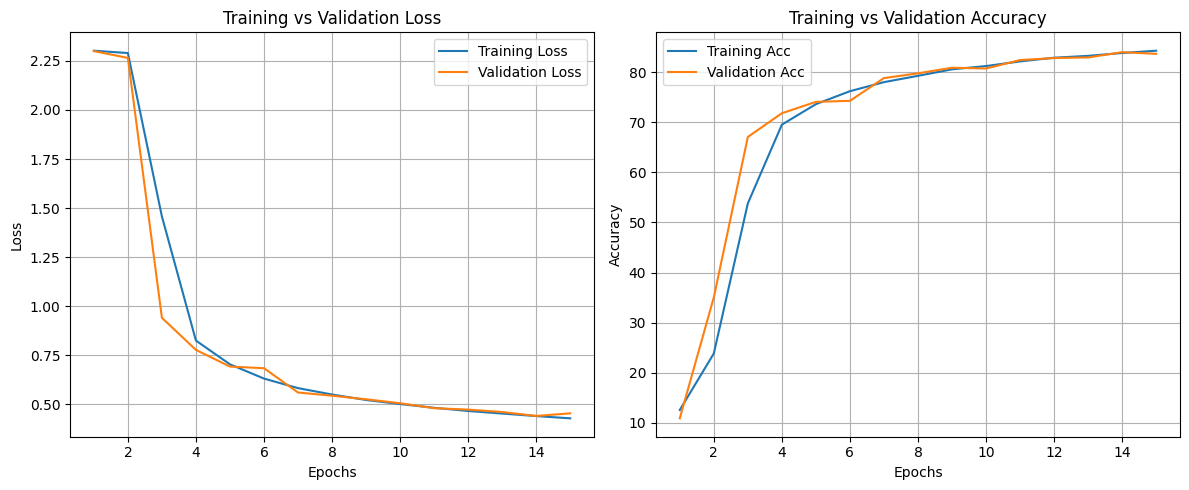

In [33]:
# CODE HERE
# Plot the "Training vs Validation Loss"

epochs_range = range(1, epochs + 1)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, [acc * 100 for acc in train_accs], label='Training Acc')
plt.plot(epochs_range, [acc * 100 for acc in val_accs], label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<div class="alert alert-success">
    <h3>7) Evaluate on test set</h3>
    report accuracy on test set. Then report the model performance by showing the test accuracy (1 point)
</div>

In [34]:
# CODE HERE
# Test the model on the test set

test_loss, test_acc = evaluate(model, test_loader, criterion, device)


print(f"[Fashion-MNIST test] Loss = {test_loss:.4f} | Acc = {test_acc*100:.2f}%")

[Fashion-MNIST test] Loss = 0.4737 | Acc = 83.16%


<div class="alert alert-success">
    <h3>8) Discussion prompts (2 point)</h3>
    (a) Which techniques from Table 3 report better performance than your method? Which performs worse? Why do you think this is the case? Briefly explain. (1 point)<br>
    (b) Do you have any other ideas about how to improve your method? Briefly explain. (1 point)
</div>

# Part 2: Image Classification — CIAFR-100 (14 points)

**Goal:** Build and train a lightweight CNN on CIAFR-100 following the given architecture and specs.

In [35]:
# import something you may find useful
import os, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import datasets, transforms
import numpy as np

import matplotlib
import matplotlib.pyplot as plt


def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)


Device: cuda


<div class="alert alert-success">
    <h3>1) Data</h3>
    load CIFAR-100 and create train/val/test splits (1 point)
</div>

In [36]:
# CIFAR-100 normalization stats
CIFAR100_MEAN = (0.5071, 0.4867, 0.4408)
CIFAR100_STD = (0.2675, 0.2565, 0.2761)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR100_MEAN, CIFAR100_STD),
])


# Load CIFAR-100 (train + test)
# Use the following code to load the CIFAR-100 if you want, or you can download the data manually
train_full = datasets.CIFAR100(root=data_dir, train=True,  download=True, transform=transform)
test_ds = datasets.CIFAR100(root=data_dir, train=False, download=True, transform=transform)



In [37]:
# CODE HERE
# Define the training, validation, and test datasets. 
# Note that you may want to select the validation set from the training set by randomly splitting the data


split = 0.2
num_trainfull = len(train_full)
num_val = int(split * num_trainfull)
num_train = num_trainfull - num_val

train_ds, val_ds = random_split(
    train_full,
    [num_train, num_val],
    generator=torch.Generator().manual_seed(42)
)


batch_size = 64
# You may want to verify the data
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

len(train_ds), len(val_ds), len(test_ds)

(40000, 10000, 10000)

<div class="alert alert-success">
    <h3>2) Model</h3>
    Build the CNN model (4 points)
</div>

In [38]:
# Define the network architecture
class SmallCNN(nn.Module):
    def __init__(self):
        # CODE HERE
        # Define the convolutional layers, pooling layers...
        super().__init__()

        # using more filters and layers to try to get more accuracy to handle the complexity of CIFAR-100
        self.conv10 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv16 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        
        self.fc1 = nn.Linear(3200, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 100)  

    def forward(self, x):
        # CODE HERE
        # Implement the forward pass. Return the final output.
        x = self.conv10(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv16(x)
        x = F.relu(x)
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        out = self.fc3(x)

        return out


# You may want to verify the architecture of CNN
model = SmallCNN().to(device)
model

SmallCNN(
  (conv10): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv16): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3200, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=100, bias=True)
)

<div class="alert alert-success">
    <h3>3) Loss & Optimizer</h3>
    CrossEntropy + SGD (1 point)
</div>

In [39]:

criterion = nn.CrossEntropyLoss()

lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)



# You may want to verify the criterion and optimizer
criterion, optimizer

(CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.1
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

<div class="alert alert-success">
    <h3>4) Training loop</h3>
    track training and validation loss (1 points)
</div>

In [40]:
# CODE HERE
# Train the network for each epoch
def train_one_epoch(model, data, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in data:
        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)
        loss = criterion(output, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = output.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


# CODE HERE
# Evaluate the model on the validation set
@torch.no_grad()
def evaluate(model, data, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0 

    for inputs, targets in data:
        inputs = inputs.to(device)
        targets = targets.to(device)

        output = model(inputs)
        loss = criterion(output, targets)

        running_loss += loss.item() * inputs.size(0)
        _, predicted = output.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

<div class="alert alert-success">
    <h3>5) Run training</h3>
    ≥ 15 epochs (1 point)
</div>

In [41]:
# CODE HERE
# Set the training epochs
epochs = 15
train_losses, val_losses, train_accs, val_accs = [], [], [], []


# CODE HERE
# Run the training epochs
for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)


    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(va_loss)
    val_accs.append(va_acc)

    print(
    f"Epoch {epoch:2d}/{epochs} | "
    f"Train Loss: {tr_loss:7.4f} | Val Loss: {va_loss:7.4f} | "
    f"Train Acc: {tr_acc*100:6.2f}% | Val Acc: {va_acc*100:6.2f}%"
    )
    



Epoch  1/15 | Train Loss:  4.2843 | Val Loss:  3.9302 | Train Acc:   4.65% | Val Acc:   9.69%
Epoch  2/15 | Train Loss:  3.7172 | Val Loss:  3.4921 | Train Acc:  12.59% | Val Acc:  16.46%
Epoch  3/15 | Train Loss:  3.3654 | Val Loss:  3.2170 | Train Acc:  18.73% | Val Acc:  21.87%
Epoch  4/15 | Train Loss:  3.0735 | Val Loss:  2.9802 | Train Acc:  24.15% | Val Acc:  25.74%
Epoch  5/15 | Train Loss:  2.8083 | Val Loss:  2.7938 | Train Acc:  29.22% | Val Acc:  30.84%
Epoch  6/15 | Train Loss:  2.5464 | Val Loss:  2.7480 | Train Acc:  34.94% | Val Acc:  32.03%
Epoch  7/15 | Train Loss:  2.2902 | Val Loss:  2.6560 | Train Acc:  40.15% | Val Acc:  33.70%
Epoch  8/15 | Train Loss:  2.0212 | Val Loss:  2.7367 | Train Acc:  46.11% | Val Acc:  33.65%
Epoch  9/15 | Train Loss:  1.7527 | Val Loss:  2.7808 | Train Acc:  52.22% | Val Acc:  33.65%
Epoch 10/15 | Train Loss:  1.4781 | Val Loss:  2.8757 | Train Acc:  58.19% | Val Acc:  34.96%
Epoch 11/15 | Train Loss:  1.2096 | Val Loss:  3.1269 | Trai

<div class="alert alert-success">
    <h3>6) Plot</h3>
    training vs validation loss (1 point)
</div>

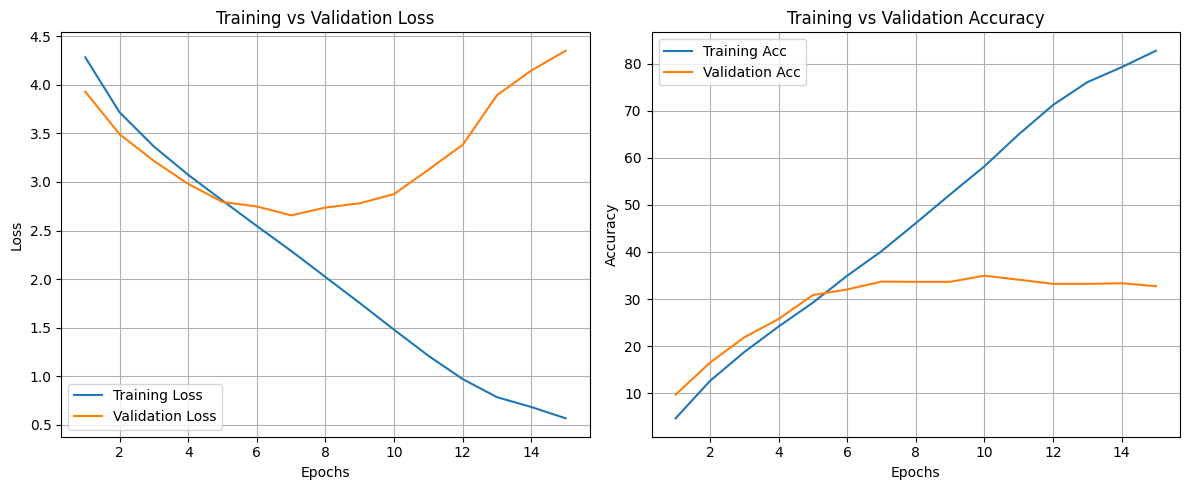

In [42]:
# CODE HERE
# Plot the "Training vs Validation Loss"

epochs_range = range(1, epochs + 1)


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, [acc * 100 for acc in train_accs], label='Training Acc')
plt.plot(epochs_range, [acc * 100 for acc in val_accs], label='Validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<div class="alert alert-success">
    <h3>7) Evaluate on test set</h3>
    report accuracy (1 point)
</div>

In [43]:
# CODE HERE
# Test the model on the test set

test_loss, test_acc = evaluate(model, test_loader, criterion, device)


print(f"[Fashion-MNIST test] Loss = {test_loss:.4f} | Acc = {test_acc*100:.2f}%")

[Fashion-MNIST test] Loss = 4.3856 | Acc = 32.32%


<div class="alert alert-success">
    <h3>8) Discussion prompts (4 points)</h3>
    (a) Compared to your Fashion-MNIST results in Part 1, how did the training and validation curves change on CIFAR-100? Did you observe more overfitting, underfitting, or slower convergence? Explain briefly. (1 point)<br>
    (b) Based on the ResNet results above (around $80\%$ accuracy) and your own results (around $35$-$45\%$), what architectural differences do you think account for most of the performance gap? Consider depth, width (number of channels), skip connections, and data augmentation, and any modifications you have made to your own architecture. (2 point)<br>
    (c) What change did you make to your architecture that you were most surprised about?
This could be a large increase or decrease in performance, or something you added that
didn’t change anything. What is your big takeaway from that experience? (1 point)<br>
    
</div>